In [1]:
import pandas as pd

crsp = pd.read_pickle("Data/crsp.pkl")
price = pd.read_pickle('Data/price.pkl')
dividends = pd.read_pickle('Data/dividends.pkl')
bookvalue = pd.read_pickle('Data/bookvalue.pkl')
shrout = pd.read_pickle('Data/shrout.pkl')
bm_dec = pd.read_pickle('Data/bm_dec.pkl')

In [3]:
bm_dec.index = pd.to_datetime(bm_dec.index)

In [5]:
"""
    I need a dataframe which comprises returns of each position in the portfolio, every year

    Challenge is now to get structure right. all stocks of portfolio for every year in one df‚

"""
price_minus_long_monthly = []
price_minus_short_monthly = []

dividends_m_long_monthly = []
dividends_m_short_monthly = []

price_long_monthly = []
price_short_monthly = []

bottom_permnos = []
top_permnos = []

for year in sorted(set(date.year for date in bm_dec.index)):
     
    date = pd.Timestamp(f"{year}-06")
    date_dec = pd.Timestamp(f"{year-1}-12")
    if date_dec not in bm_dec.index:
        continue
    if year == 2018:
        continue
    # Timeframe: July-June
    month_range = pd.date_range(start=date + pd.DateOffset(months=1), periods=12, freq="ME")
    month_range = month_range.to_period('M')

    target_date = f"{year}-06" 
    top_date = pd.to_datetime(target_date)
    crsp['date'] = pd.to_datetime(crsp['date'])

    #Top Permnos
    if len(top_permnos) == 0:
        print("This is year: ", year) #Dummy
    else:
        for m in month_range:
            #Computations for monthly returns
            date = m.to_timestamp()
            shrout_filtered_m_long_monthly = crsp[(crsp['date'] == date) & (crsp['permno'].isin(top_permnos))]
            shrout_series_m_long_monthly = shrout_filtered_m_long_monthly.set_index('permno')['adj_shrout']
            top_m_prc_monthly = price.loc[date, price.columns.intersection(top_permnos)].dropna()
            sharesoutstanding_long_m_prc = shrout_series_m_long_monthly.reindex(top_m_prc_monthly.index) *1000
            long_m_prc_monthly = top_m_prc_monthly * sharesoutstanding_long_m_prc
            for permno, value in long_m_prc_monthly.items():
                price_minus_long_monthly.append({'date': date, 'permno': permno, 'avg_value': value})

            #Dividends
            top_m_div = dividends.loc[date, dividends.columns.intersection(top_permnos)].dropna()
            sharesoutstanding_long_m_div = shrout_series_m_long_monthly.reindex(top_m_div.index) *1000
            long_m_div = top_m_div * sharesoutstanding_long_m_div
            for permno, value in long_m_div.items():
                dividends_m_long_monthly.append({'date': date, 'permno': permno, 'avg_value': value})

        #dividends_m_long_ts.extend(dividends_m_long_monthly)


    #Bottom Permnos
    if len(bottom_permnos) == 0:
        print("This is year (bottom): ", year) #Dummy
    else:

        for m in month_range:
            #Computations for monthly returns
            date = m.to_timestamp()
            shrout_filtered_m_short_monthly = crsp[(crsp['date'] == date) & (crsp['permno'].isin(bottom_permnos))]
            shrout_series_m_short_monthly = shrout_filtered_m_short_monthly.set_index('permno')['adj_shrout']
            bottom_m_prc_monthly = price.loc[date, price.columns.intersection(bottom_permnos)].dropna()
            sharesoutstanding_short_m_prc_monthly = shrout_series_m_short_monthly.reindex(bottom_m_prc_monthly.index) *1000
            short_m_prc_monthly = bottom_m_prc_monthly * sharesoutstanding_short_m_prc_monthly
            for permno, value in short_m_prc_monthly.items():
                price_minus_short_monthly.append({'date': date, 'permno': permno, 'avg_value': value})

            #Dividends
            bottom_m_div = dividends.loc[date, dividends.columns.intersection(bottom_permnos)].dropna()
            sharesoutstanding_short_m_div = shrout_series_m_short_monthly.reindex(bottom_m_div.index) *1000
            short_m_div = bottom_m_div * sharesoutstanding_short_m_div
            for permno, value in short_m_div.items():
                dividends_m_short_monthly.append({'date': date, 'permno': permno, 'avg_value': value})

    """"
        Stock Selection:

        All Stocks in the available Dataset are being sorted in a descending order by Book-to-market ratio.

        "Clean Row" accesses the DataFrame bm_dec, which contains the book-to-market ratios in wide-format. 
        Therefore the length of a row is equal to the number of available stocks. Since the only condition for a stock
        to be picked is that it is listed at the day of the portfolio selection, there is no look-ahead bias.

        The top 30% of stocks are being selected for the long-positions, the bottom 30% for the short-positions, respectively.


    """
    #Only stocks which contain values for June of a year get selected. Later months are not considered -> no look-ahead bias
    clean_row = bm_dec.loc[date_dec].dropna().sort_values(ascending=False) 
    n = len(clean_row)
    if n == 0:
        continue

    k = int(n * 0.3)
    bottom_permnos = clean_row.iloc[:k].index.tolist() #Selects permnos with the lower B/M-ratios
    top_permnos = clean_row.iloc[-k:].index.tolist() #Selects permnos with the higher B/M-ratios

    for m in month_range:
        #Computations for monthly returns
        date = m.to_timestamp()
        #Short-Positions
        shrout_filtered_short_monthly = crsp[(crsp['date'] == date) & (crsp['permno'].isin(bottom_permnos))]
        shrout_series_short_monthly = shrout_filtered_short_monthly.set_index('permno')['adj_shrout']
        bottom_prc_monthly = price.loc[date, price.columns.intersection(bottom_permnos)].dropna()
        sharesoutstanding_short_prc_monthly = shrout_series_short_monthly.reindex(bottom_prc_monthly.index) *1000
        short_prc_monthly = bottom_prc_monthly * sharesoutstanding_short_prc_monthly
        """if short_prc_monthly.notna().any():
            price_short_monthly.append({'date': date, 'avg_value': short_prc_monthly.sum()})
        else:
            print(f"No valid prices for {date} — skipping.")"""

        for permno, value in short_prc_monthly.items():
                price_short_monthly.append({'date': date, 'permno': permno, 'avg_value': value})
        
        #Long-Positions
        shrout_filtered_long_monthly = crsp[(crsp['date'] == date) & (crsp['permno'].isin(top_permnos))]
        shrout_series_long_monthly = shrout_filtered_long_monthly.set_index('permno')['adj_shrout']
        top_prc_monthly = price.loc[date, price.columns.intersection(top_permnos)].dropna()
        sharesoutstanding_long_prc_monthly = shrout_series_long_monthly.reindex(top_prc_monthly.index) *1000
        long_prc_monthly = top_prc_monthly * sharesoutstanding_long_prc_monthly
        """if long_prc_monthly.notna().any():
            price_long_monthly.append({'date': date, 'avg_value': long_prc_monthly.sum()})
        else:
            print(f"No valid prices for {date} — skipping.")"""
        for permno, value in long_prc_monthly.items():
                price_long_monthly.append({'date': date, 'permno': permno, 'avg_value': value})


This is year:  1961
This is year (bottom):  1961


In [28]:
df_price_minus_long_monthly = pd.DataFrame(price_minus_long_monthly).set_index(['date', 'permno'])
df_price_minus_short_monthly = pd.DataFrame(price_minus_short_monthly).set_index(['date', 'permno'])
df_price_minus_long_monthly.rename(columns={'avg_value':'Price_long'}, inplace=True)
df_price_minus_short_monthly.rename(columns={'avg_value':'Price_short'}, inplace=True)

df_price_long_monthly = pd.DataFrame(price_long_monthly).set_index(['date', 'permno'])
df_price_short_monthly = pd.DataFrame(price_short_monthly).set_index(['date', 'permno'])
df_price_long_monthly.rename(columns={'avg_value':'Price_long_lagged'}, inplace=True)
df_price_short_monthly.rename(columns={'avg_value':'Price_short_lagged'}, inplace=True)

df_dividends_long = pd.DataFrame(dividends_m_long_monthly).set_index(['date', 'permno'])
df_dividends_short = pd.DataFrame(dividends_m_short_monthly).set_index(['date', 'permno'])
df_dividends_long.rename(columns={'avg_value':'Dividends_long'}, inplace=True)
df_dividends_short.rename(columns={'avg_value':'Dividends_short'}, inplace=True)

In [30]:
df_price_minus_long_monthly

Price_long
date       permno              
1962-07-01 10153   1.410570e+08
           10268   9.849000e+06
           10364   2.725170e+08
           10487   8.559688e+07
           10559   1.676370e+08
...                         ...
2018-06-01 93399   2.310002e+07
           93420   4.115485e+09
           93422   2.914300e+09
           93426   4.741664e+08
           93427   1.361315e+09

[589244 rows x 1 columns]

In [100]:
returns = pd.DataFrame(endog[['date', 'permno', 'return']]).set_index(['date', 'permno'])
returns

,,return
date,permno,
1988-08-01,10001,0.029126
1988-09-01,10001,-0.015212
1988-10-01,10001,0.039216
1988-11-01,10001,0.000000
1988-12-01,10001,-0.021132
...,...,...
2018-02-01,93426,0.093066
2018-03-01,93426,0.051599
2018-04-01,93426,-0.089954


In [214]:
from tqdm.notebook import tqdm

In [ ]:
# ============================================================================
# Rolling Beta Computation with CRSP Data - Jupyter Notebook Version
# ============================================================================

# Cell 1: Import libraries and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
from IPython.display import display, HTML

# Try to import tqdm for progress bars
try:
    from tqdm.notebook import tqdm
    TQDM_AVAILABLE = True
    print("✅ tqdm imported successfully")
except ImportError:
    try:
        from tqdm import tqdm
        TQDM_AVAILABLE = True
        print("✅ tqdm (standard) imported successfully")
    except ImportError:
        TQDM_AVAILABLE = False
        print("⚠️ tqdm not available - progress bars disabled")
        # Define dummy tqdm function
        def tqdm(iterable, desc="Processing"):
            return iterable

# Optional plotly import
try:
    import plotly.express as px
    import plotly.graph_objects as go
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("⚠️ plotly not available - using matplotlib only")

# Notebook settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        pass  # Use default style

try:
    sns.set_palette("husl")
except:
    pass  # Use default palette

print("✅ Libraries imported successfully!")

# ============================================================================
# Cell 2: Market Return Computation Function
# ============================================================================

def compute_market_return(crsp_data, value_weighted=True, show_stats=True):
    """
    Compute market return from CRSP data with Jupyter-friendly output.
    
    Parameters:
    crsp_data: DataFrame with columns ['date', 'permno', 'ret', 'market_equity'] 
    value_weighted: If True, compute value-weighted return; if False, equal-weighted
    show_stats: Display summary statistics
    
    Returns:
    DataFrame with date and market return
    """
    print(f"🔄 Computing {'value-weighted' if value_weighted else 'equal-weighted'} market return...")
    
    crsp_clean = crsp_data.copy()
    crsp_clean['date'] = pd.to_datetime(crsp_clean['date'])
    
    if value_weighted:
        # Value-weighted market return
        crsp_clean = crsp_clean.sort_values(['permno', 'date'])
        crsp_clean['me_lag'] = crsp_clean.groupby('permno')['market_equity'].shift(1)
        
        # Remove observations with missing data
        market_data = crsp_clean.dropna(subset=['ret', 'me_lag'])
        
        # Compute value-weighted return for each date
        market_ret = market_data.groupby('date').apply(
            lambda x: np.average(x['ret'], weights=x['me_lag'])
        ).reset_index()
        market_ret.columns = ['date', 'mkt_ret']
        
    else:
        # Equal-weighted market return
        market_ret = crsp_clean.groupby('date')['ret'].mean().reset_index()
        market_ret.columns = ['date', 'mkt_ret']
    
    if show_stats:
        print(f"📊 Market return computed for {len(market_ret)} periods")
        print(f"📅 Date range: {market_ret['date'].min()} to {market_ret['date'].max()}")
        
        # Display summary statistics
        stats = market_ret['mkt_ret'].describe()
        stats_df = pd.DataFrame({
            'Market Return Statistics': [f"{val:.4f}" for val in stats.values]
        }, index=stats.index)
        display(stats_df)
        
        # Quick plot
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(market_ret['date'], market_ret['mkt_ret'], linewidth=1)
        ax.set_title('Market Return Over Time', fontsize=14, fontweight='bold')
        ax.set_xlabel('Date')
        ax.set_ylabel('Market Return')
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    return market_ret

# ============================================================================
# Cell 3: Rolling Beta Regression Function
# ============================================================================

def rolling_beta_regression(stock_returns, market_returns, window=36, min_obs=12):
    """
    Compute rolling beta using linear regression with enhanced output.
    
    Parameters:
    stock_returns: Series of stock returns
    market_returns: Series of market returns
    window: Rolling window size in months
    min_obs: Minimum observations required
    
    Returns:
    DataFrame with beta, alpha, r_squared, and other stats
    """
    results = {
        'beta': [],
        'alpha': [],
        'r_squared': [],
        'valid_obs': []
    }
    
    for i in range(len(stock_returns)):
        if i < window - 1:
            for key in results:
                results[key].append(np.nan)
        else:
            # Get window of data
            y = stock_returns.iloc[i-window+1:i+1].values
            x = market_returns.iloc[i-window+1:i+1].values
            
            # Remove any NaN observations
            valid_idx = ~(np.isnan(y) | np.isnan(x))
            y_clean = y[valid_idx]
            x_clean = x[valid_idx]
            
            if len(y_clean) >= min_obs:
                try:
                    # Fit regression
                    reg = LinearRegression()
                    reg.fit(x_clean.reshape(-1, 1), y_clean)
                    
                    # Calculate R-squared
                    y_pred = reg.predict(x_clean.reshape(-1, 1))
                    ss_res = np.sum((y_clean - y_pred) ** 2)
                    ss_tot = np.sum((y_clean - np.mean(y_clean)) ** 2)
                    r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
                    
                    results['beta'].append(reg.coef_[0])
                    results['alpha'].append(reg.intercept_)
                    results['r_squared'].append(r_squared)
                    results['valid_obs'].append(len(y_clean))
                    
                except Exception as e:
                    for key in results:
                        results[key].append(np.nan)
            else:
                for key in results:
                    results[key].append(np.nan)
    
    return pd.DataFrame(results, index=stock_returns.index)

# ============================================================================
# Cell 4: Main Rolling Beta Computation Function
# ============================================================================

def compute_rolling_betas(crsp_data, market_data=None, window=36, min_obs=12, 
                         max_stocks=None, show_progress=True):
    """
    Main function to compute rolling betas with Jupyter-friendly features.
    
    Parameters:
    crsp_data: DataFrame with CRSP stock data
    market_data: DataFrame with market returns (optional)
    window: Rolling window size in months
    min_obs: Minimum observations required
    max_stocks: Limit number of stocks (for testing)
    show_progress: Show progress bar
    
    Returns:
    DataFrame with rolling betas and statistics
    """
    
    print("🚀 Starting rolling beta computation...")
    print(f"📊 Dataset shape: {crsp_data.shape}")
    
    # Compute market return if not provided
    if market_data is None:
        print("\n" + "="*50)
        print("📈 Computing market return from CRSP data...")
        market_data = compute_market_return(crsp_data, value_weighted=True)
        print("="*50 + "\n")
    
    # Prepare data
    crsp_clean = crsp_data.copy()
    crsp_clean['date'] = pd.to_datetime(crsp_clean['date'])
    market_data['date'] = pd.to_datetime(market_data['date'])
    
    # Merge with market data
    merged_data = crsp_clean.merge(market_data, on='date', how='left')
    
    # Get unique stocks
    unique_stocks = merged_data['permno'].unique()
    if max_stocks:
        unique_stocks = unique_stocks[:max_stocks]
        print(f"🔬 Processing first {max_stocks} stocks for testing")
    
    print(f"🏢 Processing {len(unique_stocks)} stocks with {window}-month rolling window")
    
    # Initialize results
    results = []
    
    # Progress bar setup
    if show_progress and TQDM_AVAILABLE:
        pbar = tqdm(unique_stocks, desc="Computing betas")
    else:
        pbar = unique_stocks
        if show_progress and not TQDM_AVAILABLE:
            print("Processing stocks... (install tqdm for progress bar)")
    
    # Process each stock
    processed_count = 0
    for i, permno in enumerate(pbar):
        if not TQDM_AVAILABLE and show_progress and i % 10 == 0:
            print(f"Processed {i}/{len(unique_stocks)} stocks...")
            
        stock_data = merged_data[merged_data['permno'] == permno].sort_values('date')
        
        if len(stock_data) < window:
            continue
        
        # Compute rolling statistics
        rolling_stats = rolling_beta_regression(
            stock_data['ret'], 
            stock_data['mkt_ret'], 
            window=window,
            min_obs=min_obs
        )
        
        # Combine with stock data
        stock_results = pd.DataFrame({
            'permno': permno,
            'date': stock_data['date'],
            'ret': stock_data['ret'],
            'mkt_ret': stock_data['mkt_ret'],
            'beta': rolling_stats['beta'],
            'alpha': rolling_stats['alpha'],
            'r_squared': rolling_stats['r_squared'],
            'valid_obs': rolling_stats['valid_obs']
        })
        
        results.append(stock_results)
    
    # Combine results
    final_results = pd.concat(results, ignore_index=True)
    
    print(f"\n✅ Computation complete!")
    print(f"📊 Final dataset shape: {final_results.shape}")
    print(f"📈 Betas computed for {final_results['permno'].nunique()} stocks")
    
    return final_results

# ============================================================================
# Cell 5: Analysis and Visualization Functions
# ============================================================================

def analyze_betas(beta_df, sample_stocks=5):
    """Display comprehensive beta analysis with visualizations."""
    
    print("📊 ROLLING BETA ANALYSIS SUMMARY")
    print("="*50)
    
    # Overall statistics
    beta_stats = beta_df['beta'].describe()
    print("\n🎯 Beta Distribution Statistics:")
    display(pd.DataFrame({'Value': beta_stats}).round(4))
    
    # Time series statistics
    print(f"\n📅 Time Period: {beta_df['date'].min()} to {beta_df['date'].max()}")
    print(f"🏢 Number of stocks: {beta_df['permno'].nunique():,}")
    print(f"📊 Total observations: {len(beta_df):,}")
    print(f"✅ Valid beta observations: {beta_df['beta'].notna().sum():,}")
    
    # Beta distribution plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Histogram
    beta_df['beta'].hist(bins=50, ax=ax1, alpha=0.7)
    ax1.axvline(beta_df['beta'].median(), color='red', linestyle='--', label='Median')
    ax1.set_title('Beta Distribution', fontweight='bold')
    ax1.set_xlabel('Beta')
    ax1.legend()
    
    # Time series of average beta
    monthly_beta = beta_df.groupby('date')['beta'].mean()
    monthly_beta.plot(ax=ax2)
    ax2.set_title('Average Beta Over Time', fontweight='bold')
    ax2.set_ylabel('Average Beta')
    
    # R-squared distribution
    beta_df['r_squared'].hist(bins=50, ax=ax3, alpha=0.7, color='green')
    ax3.set_title('R-squared Distribution', fontweight='bold')
    ax3.set_xlabel('R-squared')
    
    # Beta vs R-squared scatter
    sample_data = beta_df.dropna().sample(min(10000, len(beta_df.dropna())))
    ax4.scatter(sample_data['beta'], sample_data['r_squared'], alpha=0.3)
    ax4.set_title('Beta vs R-squared', fontweight='bold')
    ax4.set_xlabel('Beta')
    ax4.set_ylabel('R-squared')
    
    plt.tight_layout()
    plt.show()
    
    # Sample individual stock betas
    print(f"\n📈 Sample of {sample_stocks} individual stock beta time series:")
    sample_permnos = beta_df['permno'].unique()[:sample_stocks]
    
    plt.figure(figsize=(15, 8))
    for i, permno in enumerate(sample_permnos):
        stock_data = beta_df[beta_df['permno'] == permno]
        plt.plot(stock_data['date'], stock_data['beta'], 
                label=f'PERMNO {permno}', alpha=0.8, linewidth=2)
    
    plt.title('Sample Individual Stock Betas Over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Beta')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ============================================================================
# Cell 6: Data Diagnostics and Debugging
# ============================================================================

def diagnose_crsp_data(crsp_data):
    """Comprehensive data diagnostics to identify issues."""
    
    print("🔍 CRSP DATA DIAGNOSTICS")
    print("="*50)
    
    # Basic info
    print(f"📊 Dataset shape: {crsp_data.shape}")
    print(f"📋 Columns: {list(crsp_data.columns)}")
    
    # Check for required columns
    required_cols = ['date', 'permno', 'ret']
    missing_cols = [col for col in required_cols if col not in crsp_data.columns]
    if missing_cols:
        print(f"❌ Missing required columns: {missing_cols}")
        return False
    
    print("✅ All required columns present")
    
    # Data types
    print(f"\n📋 Data types:")
    display(crsp_data.dtypes.to_frame('dtype'))
    
    # Check date column
    print(f"\n📅 Date column analysis:")
    print(f"   Date type: {type(crsp_data['date'].iloc[0])}")
    print(f"   Sample dates: {crsp_data['date'].head().tolist()}")
    print(f"   Date range: {crsp_data['date'].min()} to {crsp_data['date'].max()}")
    print(f"   Unique dates: {crsp_data['date'].nunique()}")
    
    # Check returns
    print(f"\n📈 Returns analysis:")
    ret_stats = crsp_data['ret'].describe()
    print(f"   Non-null returns: {crsp_data['ret'].notna().sum():,} / {len(crsp_data):,}")
    print(f"   Return range: {crsp_data['ret'].min():.6f} to {crsp_data['ret'].max():.6f}")
    print(f"   Mean return: {crsp_data['ret'].mean():.6f}")
    print(f"   Returns that look like percentages (>1): {(crsp_data['ret'] > 1).sum()}")
    
    # Check for extreme values
    extreme_returns = crsp_data['ret'].abs() > 2  # Returns > 200%
    if extreme_returns.any():
        print(f"   ⚠️ Extreme returns (>200%): {extreme_returns.sum()}")
    
    # Check PERMNOs
    print(f"\n🏢 Stock identifiers:")
    print(f"   Unique PERMNOs: {crsp_data['permno'].nunique()}")
    print(f"   Sample PERMNOs: {crsp_data['permno'].unique()[:10].tolist()}")
    
    # Check market equity if available
    if 'me' in crsp_data.columns:
        print(f"\n💰 Market equity:")
        print(f"   Non-null ME: {crsp_data['market_equity'].notna().sum():,}")
        print(f"   ME range: {crsp_data['market_equity'].min():.2f} to {crsp_data['market_equity'].max():.2f}")
    else:
        print(f"\n⚠️ No 'me' column found - will compute equal-weighted market return")
    
    # Sample data
    print(f"\n📊 Sample data:")
    display(crsp_data.head(10))
    
    # Check for missing data patterns
    print(f"\n🔍 Missing data pattern:")
    missing_summary = crsp_data.isnull().sum()
    if missing_summary.any():
        display(missing_summary[missing_summary > 0].to_frame('Missing Count'))
    else:
        print("   ✅ No missing data found")
    
    return True

# ============================================================================
# Cell 7: Enhanced Example Usage with Debugging
# ============================================================================

def run_example(crsp_data, test_mode=True, debug=True):
    """Run example analysis with comprehensive debugging."""
    
    print("🎯 RUNNING ROLLING BETA ANALYSIS")
    print("="*60)
    
    if debug:
        # First diagnose the data
        if not diagnose_crsp_data(crsp_data):
            print("❌ Data diagnosis failed - please check your data format")
            return None
        
        print("\n" + "="*60)
    
    # Clean and prepare data
    print("🔧 PREPARING DATA...")
    crsp_clean = crsp_data.copy()
    
    # Ensure date is datetime
    if not pd.api.types.is_datetime64_any_dtype(crsp_clean['date']):
        print("🔄 Converting date column to datetime...")
        crsp_clean['date'] = pd.to_datetime(crsp_clean['date'])
    
    # Remove missing returns
    initial_rows = len(crsp_clean)
    crsp_clean = crsp_clean.dropna(subset=['ret'])
    print(f"📊 Removed {initial_rows - len(crsp_clean)} rows with missing returns")
    
    # Convert percentage returns if needed
    if crsp_clean['ret'].abs().mean() > 1:
        print("🔄 Converting percentage returns to decimal...")
        crsp_clean['ret'] = crsp_clean['ret'] / 100
    
    # Remove extreme returns (likely errors)
    extreme_mask = crsp_clean['ret'].abs() > 3  # >300% returns
    if extreme_mask.any():
        print(f"🔧 Removing {extreme_mask.sum()} extreme returns (>300%)")
        crsp_clean = crsp_clean[~extreme_mask]
    
    print(f"📊 Clean data shape: {crsp_clean.shape}")
    
    # Test with subset if in test mode
    if test_mode:
        print("\n🔬 Running in TEST MODE...")
        
        # Get stocks with sufficient data
        stock_counts = crsp_clean.groupby('permno').size()
        good_stocks = stock_counts[stock_counts >= 36].index[:20]  # Top 20 stocks with 36+ observations
        
        if len(good_stocks) == 0:
            print("❌ No stocks with sufficient data (36+ observations)")
            return None
            
        print(f"📊 Using {len(good_stocks)} stocks with sufficient data")
        
        # Use recent data
        recent_date = crsp_clean['date'].max()
        cutoff_date = recent_date - pd.DateOffset(years=3)  # Last 3 years
        
        test_data = crsp_clean[
            (crsp_clean['date'] >= cutoff_date) &
            (crsp_clean['permno'].isin(good_stocks))
        ]
        
        print(f"📊 Test data shape: {test_data.shape}")
        print(f"📅 Date range: {test_data['date'].min()} to {test_data['date'].max()}")
        
        if len(test_data) == 0:
            print("❌ No data remaining after filtering")
            return None
        
        # Use shorter window for testing
        betas_df = compute_rolling_betas(test_data, window=12, max_stocks=20)
        
    else:
        print("🚀 Running FULL ANALYSIS...")
        betas_df = compute_rolling_betas(crsp_clean, window=36)
    
    # Check results
    if betas_df is None or len(betas_df) == 0:
        print("❌ No results generated")
        return None
    
    valid_betas = betas_df['beta'].notna().sum()
    print(f"✅ Generated {valid_betas:,} valid beta observations")
    
    if valid_betas == 0:
        print("❌ All betas are NaN - check data quality and window size")
        return betas_df
    
    # Analyze results
    print("\n" + "="*60)
    analyze_betas(betas_df)
    
    return betas_df

# ============================================================================
# Cell 7: Data Loading Template
# ============================================================================

# UNCOMMENT AND MODIFY THE FOLLOWING TO LOAD YOUR DATA:

# Option 1: Load from CSV
# crsp_monthly = pd.read_csv('your_crsp_monthly_data.csv')

# Option 2: Load from database (example with SQLite)
# import sqlite3
# conn = sqlite3.connect('your_database.db')
# crsp_monthly = pd.read_sql('SELECT * FROM crsp_monthly', conn)

# Option 3: If you have market return data separately
# market_return = pd.read_csv('your_market_return_data.csv')

print("📝 Data loading template ready!")
print("📋 Required CRSP columns: ['date', 'permno', 'ret', 'me']")
print("📋 Optional market return columns: ['date', 'mkt_ret']")

# ============================================================================
# Cell 8: Run Analysis (Uncomment when ready)
# ============================================================================

# STEP 1: First diagnose your data
diagnose_crsp_data(crsp)  # Replace 'crsp' with your dataframe name

# STEP 2: Run analysis with debugging
betas_result = run_example(crsp, test_mode=False, debug=True)

# STEP 3: If successful, save results
# if betas_result is not None and len(betas_result) > 0:
#     betas_result.to_csv('rolling_betas_results.csv', index=False)
#     print("💾 Results saved to 'rolling_betas_results.csv'")

print("🎯 Ready to run! Follow these steps:")
print("1. First run: diagnose_crsp_data(your_dataframe)")
print("2. Then run: betas_result = run_example(your_dataframe, test_mode=True, debug=True)")
print("3. Check the diagnostic output to understand any data issues")

In [233]:
betas_result

,permno,date,ret,mkt_ret,beta,alpha,r_squared,valid_obs
0,10001,1986-12-01,0.015000,-0.025810,NaN,NaN,NaN,NaN
1,10001,1987-01-01,-0.035714,0.127590,NaN,NaN,NaN,NaN
2,10001,1987-02-01,-0.074074,0.048168,NaN,NaN,NaN,NaN
3,10001,1987-03-01,0.036800,0.020824,NaN,NaN,NaN,NaN
4,10001,1987-04-01,-0.039216,-0.016563,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2349289,93436,2018-08-01,0.011806,0.039577,0.766266,0.000422,0.043890,36.0
2349290,93436,2018-09-01,-0.122290,-0.004419,0.879584,-0.005156,0.052282,36.0
2349291,93436,2018-10-01,0.274011,-0.082394,0.373804,0.016206,0.010162,36.0
2349292,93436,2018-11-01,0.039013,0.009737,0.376496,0.014125,0.010498,36.0


In [242]:
# 1. Join dataframes indexed by ['date', 'permno']
endog = df_price_minus_long_monthly.join(df_dividends_long, how='left')
endog = endog.join(df_price_long_monthly, how='left')
endog['Dividends_long'] = endog['Dividends_long'].fillna(0)

# 2. Reset index to have 'date' and 'permno' as columns for grouping
endog = endog.reset_index()

# 3. Sort by permno and date so shift works correctly
endog = endog.sort_values(['permno', 'date'])

# 4. Compute lagged price per permno (previous month)
endog['Price_long_lagged_shifted'] = endog.groupby('permno')['Price_long_lagged'].shift(1)

# 5. Compute returns
endog['return'] = (endog['Price_long'] + endog['Dividends_long']) / endog['Price_long_lagged_shifted'] - 1

# 6. (Optional) drop rows where lagged price is NaN (no prior price to compute return)
endog = endog.dropna(subset=['Price_long_lagged_shifted'])
endog['date'] = endog['date'].dt.to_period('M')
endog

,date,permno,Price_long,Dividends_long,Price_long_lagged,Price_long_lagged_shifted,return
202035,1988-08,10001,6.572000e+06,0.000000,6.572000e+06,6.386000e+06,0.029126
203139,1988-09,10001,6.362250e+06,109779.999405,6.362250e+06,6.572000e+06,-0.015212
204236,1988-10,10001,6.611750e+06,0.000000,6.611750e+06,6.362250e+06,0.039216
205322,1988-11,10001,6.611750e+06,0.000000,6.611750e+06,6.611750e+06,0.000000
206399,1988-12,10001,6.362250e+06,109779.999405,6.362250e+06,6.611750e+06,-0.021132
...,...,...,...,...,...,...,...
586198,2018-02,93426,3.673667e+08,0.000000,3.673667e+08,3.360884e+08,0.093066
586967,2018-03,93426,3.863223e+08,0.000000,3.863223e+08,3.673667e+08,0.051599
587730,2018-04,93426,3.515709e+08,0.000000,3.515709e+08,3.863223e+08,-0.089954
588489,2018-05,93426,4.667089e+08,0.000000,4.667089e+08,3.515709e+08,0.327496


In [249]:
#Load exogs
betas = betas_result[['date', 'permno', 'beta']].dropna()

size = crsp[['date', 'permno', 'market_equity']]
size['market_equity'] = np.log(size['market_equity'])

bm = crsp[['date', 'permno', 'BM']]
bm['BM'] = abs(bm['BM'])

exogs = betas.merge(size, on=['date', 'permno'], how='inner')
exogs = exogs.merge(bm, on=['date', 'permno'], how='inner')
exogs['date'] = exogs['date'].dt.to_period('M')

merged = pd.merge(endog, exogs, on=['date', 'permno'], how='inner')

# 3. (Optional) Set MultiIndex back if you want
merged = merged.set_index(['date', 'permno'])
merged['return-forward'] = merged.groupby(level='permno')['return'].shift(-1)
merged_clean = merged.dropna()
merged

,,Price_long,Dividends_long,Price_long_lagged,Price_long_lagged_shifted,return,beta,market_equity,BM,return-forward
date,permno,,,,,,,,,
1989-11,10001,1.006262e+07,0.0,1.006262e+07,9.680500e+06,0.039474,0.043392,16.124339,0.117622,0.041031
1989-12,10001,1.034775e+07,127750.0,1.034775e+07,1.006262e+07,0.041031,0.044471,16.152280,0.103032,-0.018519
1990-01,10001,1.015612e+07,0.0,1.015612e+07,1.034775e+07,-0.018519,0.138460,16.133588,0.103032,-0.006289
1990-02,10001,1.009225e+07,0.0,1.009225e+07,1.015612e+07,-0.006289,0.176106,16.127278,0.103032,0.017613
1990-03,10001,1.014162e+07,128375.0,1.014162e+07,1.009225e+07,0.017613,0.172316,16.132159,0.103032,0.000000
...,...,...,...,...,...,...,...,...,...,...
2018-02,93426,3.673667e+08,0.0,3.673667e+08,3.360884e+08,0.093066,0.816093,19.721871,0.562074,0.051599
2018-03,93426,3.863223e+08,0.0,3.863223e+08,3.673667e+08,0.051599,0.825538,19.772183,0.562074,-0.089954
2018-04,93426,3.515709e+08,0.0,3.515709e+08,3.863223e+08,-0.089954,0.818163,19.677922,0.562074,0.327496


In [264]:
    """
        Fama-MacBetch Cross-Sectional Regression Analysis

        Error: Can´t use factor values.

        Next steps: Compute firm-level characteristics: beta, log(mktcap), B/M

        --> do regression again, with new exog variables.
    

        Two-step approach: 
        1. time-series computation of betas
        2. cross sectional regression
    """
    
import statsmodels.api as sm

    """
       Computing exog variables
    """

results_list = []

d = pd.to_datetime('2010-06-01')
year_range = pd.period_range(start='1965', end='2016', freq='Y')
for year in year_range:
        date = pd.Timestamp(f"{year}-06")
        month_range = pd.date_range(start=date + pd.DateOffset(months=1), periods=12, freq="ME")
        month_range = month_range.to_period('M')
        if year == 2017:
                continue

        for m in month_range:
            merged_t = merged_clean.loc[m]
            endog_t = merged_t['return-forward'].values
            exog_t = merged_t[['beta', 'market_equity', 'BM']]
            exog_const = sm.add_constant(exog_t)



            model = sm.OLS(endog_t, exog_const)

            res = model.fit(cov_type='HAC', cov_kwds={'maxlags': 6})

            if(year == 2000 & m.month == 12):
                print(res.summary())
            df_res = pd.DataFrame({
                'coef': res.params,
                't_stat': res.tvalues,
                'p_value': res.pvalues
            })

            df_res['date'] = m
            df_res = df_res.reset_index().rename(columns={'index': 'factor'})

            # Add overall regression stats, repeated per factor row for convenience
            df_res['R_squared'] = res.rsquared
            df_res['Adj_R_squared'] = res.rsquared_adj
            df_res['n_obs'] = int(res.nobs)

            results_list.append(df_res)

results_df = pd.concat(results_list, ignore_index=True)
results_df = results_df[['date', 'factor', 'coef', 't_stat', 'p_value', 'R_squared', 'Adj_R_squared', 'n_obs']]

print(results_df)


         date         factor      coef    t_stat   p_value  R_squared  \
0     1965-07          const -0.070153 -0.554547  0.579204   0.103611   
1     1965-07           beta  0.026573  1.674210  0.094089   0.103611   
2     1965-07  market_equity  0.003311  0.506833  0.612272   0.103611   
3     1965-07             BM  0.077449  2.230016  0.025746   0.103611   
4     1965-08          const  0.311909  2.015657  0.043836   0.138036   
...       ...            ...       ...       ...       ...        ...   
2491  2017-05             BM  0.024723  0.817566  0.413605   0.017485   
2492  2017-06          const -0.120190 -3.363126  0.000771   0.024516   
2493  2017-06           beta -0.001711 -0.329926  0.741456   0.024516   
2494  2017-06  market_equity  0.006817  3.693956  0.000221   0.024516   
2495  2017-06             BM -0.018212 -1.599112  0.109796   0.024516   

      Adj_R_squared  n_obs  
0          0.036382     44  
1          0.036382     44  
2          0.036382     44  
3      

In [272]:
#results_df.set_index('date', inplace=True)
results_df[:2000]

,factor,coef,t_stat,p_value,R_squared,Adj_R_squared,n_obs
date,,,,,,,
1965-07-01,const,-0.070153,-0.554547,0.579204,0.103611,0.036382,44
1965-07-01,beta,0.026573,1.674210,0.094089,0.103611,0.036382,44
1965-07-01,market_equity,0.003311,0.506833,0.612272,0.103611,0.036382,44
1965-07-01,BM,0.077449,2.230016,0.025746,0.103611,0.036382,44
1965-08-01,const,0.311909,2.015657,0.043836,0.138036,0.090149,58
...,...,...,...,...,...,...,...
2007-01-01,BM,-0.006076,-0.495835,0.620011,0.016354,0.012460,762
2007-02-01,const,-0.096660,-2.070912,0.038367,0.010999,0.007054,756
2007-02-01,beta,-0.000919,-0.187866,0.850982,0.010999,0.007054,756


🚀 STARTING REGRESSION RESULTS ANALYSIS
📊 Data Overview:
   Total observations: 2,496
   Unique dates: 624
   Date range: 1965-07-01 00:00:00 to 2017-06-01 00:00:00
   Factors: ['const', 'beta', 'market_equity', 'BM']

📈 Calculating Fama-MacBeth Summary Statistics...
📊 FAMA-MACBETH SUMMARY ANALYSIS
🔍 Analyzing 4 factors: ['const', 'beta', 'market_equity', 'BM']

📋 SUMMARY RESULTS:

🎯 Main Results (Fama-MacBeth):
       Factor  Mean Coef  Std Error  FM t-stat  FM p-value  CI Lower  CI Upper  % Significant
        const     0.0629     0.0087     7.2416      0.0000    0.0458    0.0799           37.2
         beta     0.0053     0.0018     2.9902      0.0029    0.0018    0.0088           35.1
market_equity    -0.0028     0.0005    -6.0478      0.0000   -0.0037   -0.0019           37.2
           BM     0.0057     0.0032     1.7710      0.0770   -0.0006    0.0120           13.6

📊 Additional Statistics:
       Factor  N Periods  Std Dev  Median     Min    Max  % Positive
        const       

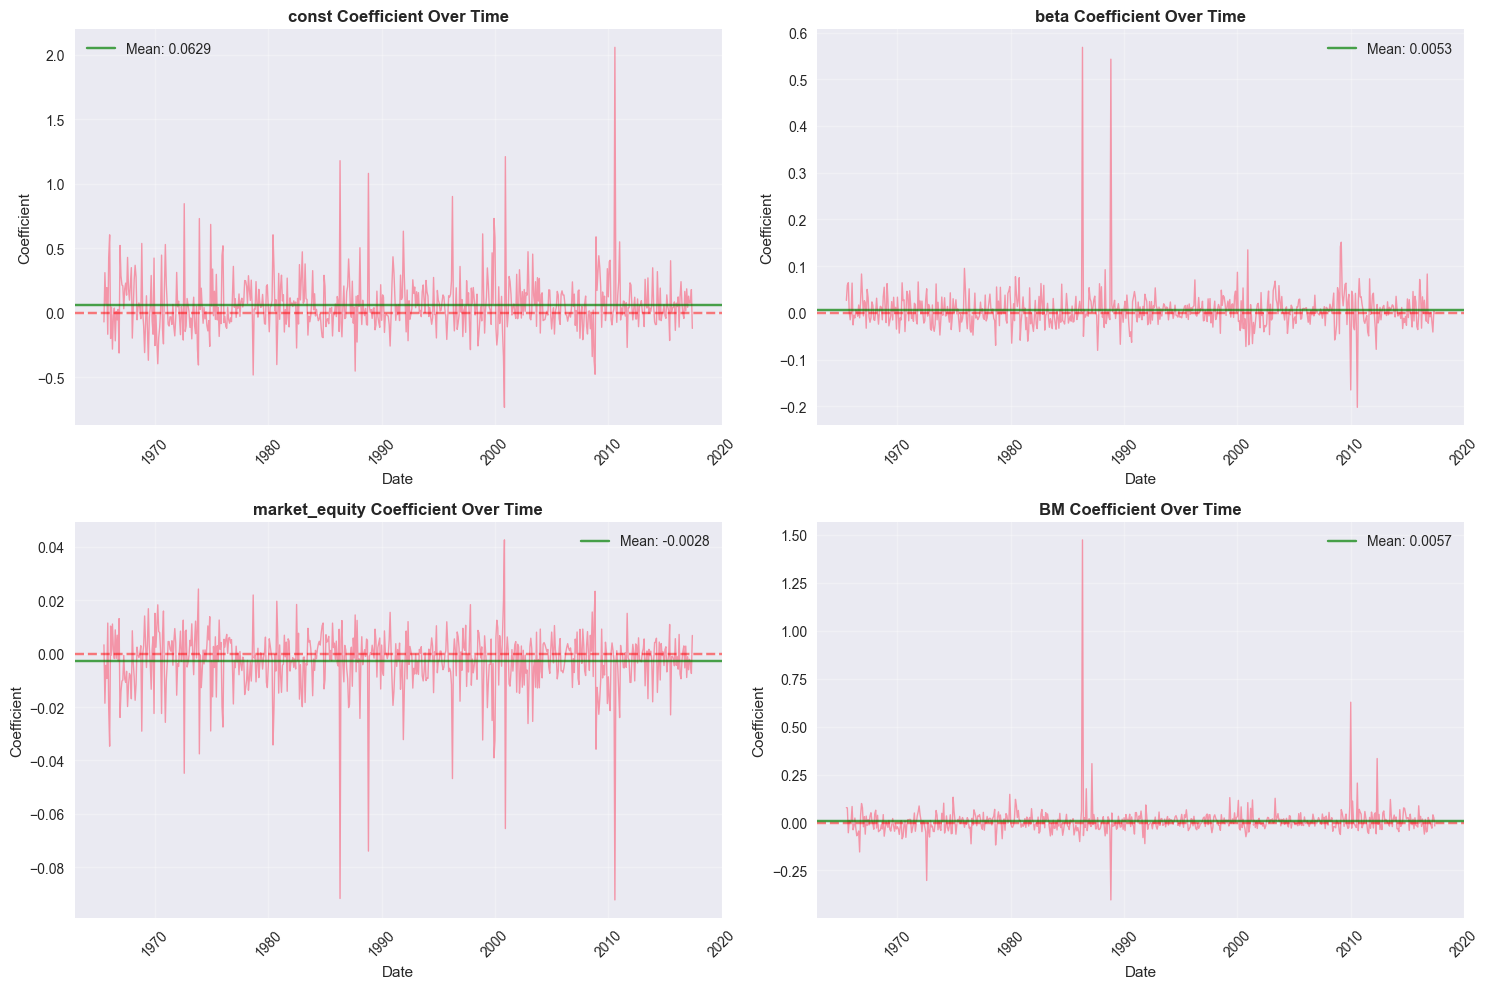


💾 Results saved to CSV files


In [265]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def fama_macbeth_summary(regression_results, confidence_level=0.95):
    """
    Calculate Fama-MacBeth style summary statistics for time-series of cross-sectional regressions.
    
    Parameters:
    regression_results: DataFrame with columns ['date', 'factor', 'coef', 't_stat', 'p_value', etc.]
    confidence_level: Confidence level for confidence intervals (default 0.95)
    
    Returns:
    DataFrame with summary statistics for each factor
    """
    
    print("📊 FAMA-MACBETH SUMMARY ANALYSIS")
    print("="*50)
    
    # Group by factor to calculate time-series statistics
    summary_stats = []
    
    # Get unique factors
    factors = regression_results['factor'].unique()
    print(f"🔍 Analyzing {len(factors)} factors: {factors.tolist()}")
    
    for factor in factors:
        factor_data = regression_results[regression_results['factor'] == factor].copy()
        factor_data = factor_data.sort_values('date')
        
        # Basic statistics
        n_periods = len(factor_data)
        mean_coef = factor_data['coef'].mean()
        std_coef = factor_data['coef'].std()
        
        # Standard error of the mean (Fama-MacBeth standard error)
        se_mean = std_coef / np.sqrt(n_periods)
        
        # t-statistic for testing if mean coefficient = 0
        t_stat_fm = mean_coef / se_mean if se_mean != 0 else np.nan
        
        # p-value (two-tailed test)
        p_value_fm = 2 * (1 - stats.t.cdf(abs(t_stat_fm), df=n_periods-1)) if not np.isnan(t_stat_fm) else np.nan
        
        # Confidence interval
        alpha = 1 - confidence_level
        t_critical = stats.t.ppf(1 - alpha/2, df=n_periods-1)
        ci_lower = mean_coef - t_critical * se_mean
        ci_upper = mean_coef + t_critical * se_mean
        
        # Additional statistics
        median_coef = factor_data['coef'].median()
        min_coef = factor_data['coef'].min()
        max_coef = factor_data['coef'].max()
        
        # Percentage of periods with significant coefficients (p < 0.05)
        pct_significant = (factor_data['p_value'] < 0.05).mean() * 100
        
        # Percentage of periods with positive coefficients
        pct_positive = (factor_data['coef'] > 0).mean() * 100
        
        # Average t-statistic and p-value from individual regressions
        avg_t_stat = factor_data['t_stat'].mean()
        avg_p_value = factor_data['p_value'].mean()
        
        summary_stats.append({
            'factor': factor,
            'n_periods': n_periods,
            'mean_coef': mean_coef,
            'std_coef': std_coef,
            'se_mean': se_mean,
            't_stat_fm': t_stat_fm,
            'p_value_fm': p_value_fm,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'median_coef': median_coef,
            'min_coef': min_coef,
            'max_coef': max_coef,
            'pct_significant': pct_significant,
            'pct_positive': pct_positive,
            'avg_t_stat_cs': avg_t_stat,
            'avg_p_value_cs': avg_p_value
        })
    
    summary_df = pd.DataFrame(summary_stats)
    
    return summary_df

def format_summary_table(summary_df, decimals=4):
    """Format the summary table for presentation."""
    
    formatted_df = summary_df.copy()
    
    # Round numerical columns
    numeric_cols = ['mean_coef', 'std_coef', 'se_mean', 't_stat_fm', 'p_value_fm', 
                   'ci_lower', 'ci_upper', 'median_coef', 'min_coef', 'max_coef',
                   'avg_t_stat_cs', 'avg_p_value_cs']
    
    for col in numeric_cols:
        if col in formatted_df.columns:
            formatted_df[col] = formatted_df[col].round(decimals)
    
    # Round percentages to 1 decimal
    pct_cols = ['pct_significant', 'pct_positive']
    for col in pct_cols:
        if col in formatted_df.columns:
            formatted_df[col] = formatted_df[col].round(1)
    
    return formatted_df

def create_coefficient_plots(regression_results, figsize=(15, 10)):
    """Create time-series plots of coefficients for each factor."""
    
    factors = regression_results['factor'].unique()
    n_factors = len(factors)
    
    # Calculate subplot layout
    cols = min(2, n_factors)
    rows = (n_factors + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if n_factors == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, factor in enumerate(factors):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        factor_data = regression_results[regression_results['factor'] == factor].copy()
        factor_data = factor_data.sort_values('date')
        
        # Convert date to datetime for plotting
        factor_data['date'] = pd.to_datetime(factor_data['date'])
        
        # Plot coefficient time series
        ax.plot(factor_data['date'], factor_data['coef'], linewidth=1, alpha=0.7)
        ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        ax.axhline(y=factor_data['coef'].mean(), color='green', linestyle='-', alpha=0.7, 
                  label=f'Mean: {factor_data["coef"].mean():.4f}')
        
        ax.set_title(f'{factor} Coefficient Over Time', fontweight='bold')
        ax.set_xlabel('Date')
        ax.set_ylabel('Coefficient')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Rotate x-axis labels
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Hide empty subplots
    for i in range(n_factors, rows * cols):
        row = i // cols
        col = i % cols
        if rows > 1:
            axes[row, col].set_visible(False)
        elif cols > 1:
            axes[col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def analyze_regression_results(regression_results, create_plots=True, save_results=False):
    """
    Complete analysis of cross-sectional regression results.
    
    Parameters:
    regression_results: DataFrame with regression results
    create_plots: Whether to create time-series plots
    save_results: Whether to save results to CSV
    
    Returns:
    Dictionary with summary statistics and formatted tables
    """
    
    print("🚀 STARTING REGRESSION RESULTS ANALYSIS")
    print("="*60)
    
    # Basic data info
    print(f"📊 Data Overview:")
    print(f"   Total observations: {len(regression_results):,}")
    print(f"   Unique dates: {regression_results['date'].nunique()}")
    print(f"   Date range: {regression_results['date'].min()} to {regression_results['date'].max()}")
    print(f"   Factors: {regression_results['factor'].unique().tolist()}")
    
    # Calculate Fama-MacBeth summary
    print(f"\n📈 Calculating Fama-MacBeth Summary Statistics...")
    summary_stats = fama_macbeth_summary(regression_results)
    
    # Format for display
    summary_display = format_summary_table(summary_stats)
    
    print(f"\n📋 SUMMARY RESULTS:")
    print("="*60)
    
    # Main results table
    main_results = summary_display[['factor', 'mean_coef', 'se_mean', 't_stat_fm', 'p_value_fm', 
                                   'ci_lower', 'ci_upper', 'pct_significant']].copy()
    main_results.columns = ['Factor', 'Mean Coef', 'Std Error', 'FM t-stat', 'FM p-value', 
                           'CI Lower', 'CI Upper', '% Significant']
    
    print("\n🎯 Main Results (Fama-MacBeth):")
    print(main_results.to_string(index=False))
    
    # Additional statistics
    additional_stats = summary_display[['factor', 'n_periods', 'std_coef', 'median_coef', 
                                       'min_coef', 'max_coef', 'pct_positive']].copy()
    additional_stats.columns = ['Factor', 'N Periods', 'Std Dev', 'Median', 'Min', 'Max', '% Positive']
    
    print(f"\n📊 Additional Statistics:")
    print(additional_stats.to_string(index=False))
    
    # Create plots if requested
    if create_plots:
        print(f"\n📈 Creating time-series plots...")
        create_coefficient_plots(regression_results)
    
    # Save results if requested
    if save_results:
        main_results.to_csv('fama_macbeth_results.csv', index=False)
        summary_stats.to_csv('detailed_regression_summary.csv', index=False)
        print(f"\n💾 Results saved to CSV files")
    
    return {
        'summary_stats': summary_stats,
        'main_results': main_results,
        'additional_stats': additional_stats,
        'formatted_summary': summary_display
    }


# Assuming your regression results are in a DataFrame called 'regression_results'

# Run complete analysis
results_df['date'] = results_df['date'].dt.to_timestamp()
results = analyze_regression_results(results_df, create_plots=True, save_results=True)

# Or just get summary statistics
#summary = fama_macbeth_summary(regression_results)
#print(summary)

In [267]:
exog_t[['beta', 'market_equity', 'BM']].corr()
#--> no multicollinearity


,beta,market_equity,BM
beta,1.000000,0.232162,0.157497
market_equity,0.232162,1.000000,0.033553
BM,0.157497,0.033553,1.000000


In [273]:
results_df.to_csv('cross-sectional-analysis.csv')

In [268]:
betas = results_df.pivot(index='date', columns='factor', values='coef')
beta_mean = betas['beta'].mean()
size_mean= betas['market_equity'].mean()
bm_mean = betas['BM'].mean()


print('Beta: ', beta_mean, 'Size: ', size_mean, 'BM: ', bm_mean)
betas

Beta:  0.0053189169343494085 Size:  -0.00280973701156471 BM:  0.00567004609179985


factor,BM,beta,const,market_equity
date,,,,
1965-07-01,0.077449,0.026573,-0.070153,0.003311
1965-08-01,0.076031,0.059277,0.311909,-0.018570
1965-09-01,-0.053436,0.064356,0.069095,-0.004359
1965-10-01,0.010259,0.000678,0.195668,-0.009299
1965-11-01,-0.000040,-0.015011,-0.165807,0.011469
...,...,...,...,...
2017-02-01,-0.014530,0.000612,0.129722,-0.006034
2017-03-01,-0.029774,-0.018894,0.077231,-0.002125
2017-04-01,0.040070,-0.041152,0.076648,-0.003538
